### Suy giảm trọng số
- Để làm giảm tình trạng overfitting thì luôn có thể tăng thêm dữ liệu huấn luyện, tuy nhiên trong nhiều trường hợp ta khó có thể có thêm dữ liệu, vì vậy nên cần sử dụng đến các phương pháp điều chuẩn.
- Một trong những phương pháp điều chuẩn là suy giảm trong số, trong đó sử dụng bình phương chuẩn trọng số trong hàm loss với hệ số điều chuẩn. Bằng cách này ta sẽ phạt nặng các trọng số lớn và làm cho trọng số trải đều chứ không tập trung vào phần tử nào.

    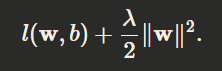
    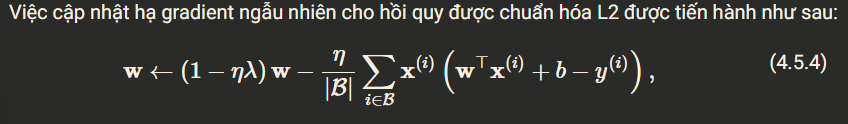

#### Hồi quy tuyến tính nhiều chiều
- Ta có thể minh họa các ưu điểm của suy giảm trọng số so với lựa chọn đặc trưng thông qua một ví dụ đơn giản với dữ liệu tự tạo. 

    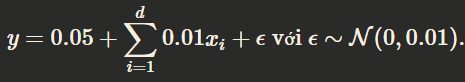
- Lựa chọn nhãn là một hàm tuyến tính của các đầu vào, bị biến dạng bởi nhiễu gauss với trung bình bằng 0 và phương sai bằng 0.01. Để làm cho hiệu ứng của việc quá khớp trở nên rõ ràng thì ta sẽ tăng số chiều của bài toán lên 200 và làm việc với tập huấn luyện nhỏ chỉ với 20 mẫu.

In [23]:
from d2l import mxnet as d2l
from mxnet import gluon, autograd, init, np, npx
from mxnet.gluon import nn

npx.set_np()

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones(shape = (num_inputs, 1)) * 0.01, 0.05
true_w.shape, true_b

((200, 1), 0.05)

In [24]:
def f(X, w, b):
    true_res = np.dot(X, w) + b
    return  true_res + np.random.normal(loc = 0, scale = 0.01, size = true_res.shape)

train_data = np.random.normal(size = (n_train, num_inputs))
train_label = f(train_data, true_w, true_b)
train_iter = d2l.load_array((train_data, train_label), batch_size)

test_data = np.random.normal(size = (n_test, num_inputs))
test_label = f(test_data, true_w, true_b)
test_iter = d2l.load_array((test_data, test_label), batch_size, is_train=False)


l1 norm of w: 0.27089342


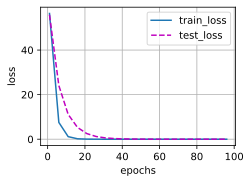

In [25]:
def init_params():
    w = np.random.normal(size = (num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()

    return w, b

def l2_penalty(w):
    return (w ** 2).sum() / 2

def square_loss(y_hat, y):
    return (y_hat - y) ** 2 / 2

def trainer(params,  lr, lambd, batch_size):
    for param in params:
        if hasattr(param, "shape"):
            param[:] = (1 - lr * lambd) * param - lr * param.grad / batch_size
        else:
            param[:]= param - lr * param.grad / batch_size

def linreg(X, w, b):
    return np.dot(X, w) + b
 
def train(lambd, train_iter, test_iter, num_epochs = 100, lr = 0.003):
    w, b = init_params()
    net = lambda X: linreg(X, w, b)
    loss = square_loss

    animator = d2l.Animator(
        xlabel="epochs", ylabel="loss", legend = ["train_loss", "test_loss"]
    )

    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            trainer([w, b], lr, lambd, y.size)
        if epoch % 5 == 0:
            animator.add([epoch + 1] * 2, (d2l.evaluate_loss(net, train_iter, loss), 
                         d2l.evaluate_loss(net, test_iter, loss)))
            
    print('l1 norm of w:', np.abs(w).sum())

train(
    lambd=3, train_iter = train_iter, test_iter = test_iter
)


l1 norm of w: 155.21808


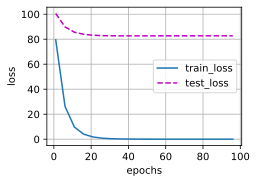

In [26]:
train(
    lambd=0, train_iter = train_iter, test_iter = test_iter
)

- Với việc training không có suy giảm trọng số thì mô hình bị overfitting do không thể giảm được lỗi trên tập test.
- Khi có suy giảm trọng số L2 với hệ số điều chỉnh là 3 thì mô hình đã có thể khái quát hóa được tập dữ liệu.